# Explore Data

## Import libraries

In [16]:
import boto3
import matplotlib.pyplot as plt
import os
import pandas as pd
import sagemaker
import seaborn as sns
import warnings

from IPython.core.display import HTML
from pyathena import connect
from wordcloud import WordCloud

# Suppress future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Filter out the specific UserWarning related to DBAPI2 objects
warnings.filterwarnings('ignore', message="pandas only supports SQLAlchemy connectable")

In [4]:
# check stored variables
%store

Stored variables and their in-db values:
bucket_name                           -> 'wizard-of-tasks-dataset-5432'
setup_dependencies_passed             -> True
setup_s3_bucket_passed                -> True


## Pull Data from Athena

In [5]:
# save Amazon information
account_id = boto3.client("sts").get_caller_identity().get("Account")
region = boto3.Session().region_name
role = sagemaker.get_execution_role()
sagemaker_session = sagemaker.Session()
s3 = boto3.client('s3', region_name=sagemaker_session.boto_region_name)

In [6]:
# get bucket_name
%store -r bucket_name
print(bucket_name)

# set S3 staging directory
s3_staging_dir = "s3://{0}/athena/staging".format(bucket_name)

# create connection
conn = connect(region_name=region, s3_staging_dir=s3_staging_dir)

wizard-of-tasks-dataset-5432


In [7]:
# set database name and table name
database_name = "wizard_of_tasks"
table_name = "data"

# pull data
statement = """SELECT * FROM {}.{}""".format(
    database_name, table_name
)
df = pd.read_sql(statement, conn)
df.head(5)

,question,intent_question,history,conversation_id,document_url_question,domain_question,text_answer,intent_answer,domain_answer,question_id,title,description,ingredients,steps
0,How do we prepare the tree?,ask_question_recipe_steps,student: I'm ready for the first step now plea...,Wizard-of-Task-diy-1,https://www.wikihow.com/Start-a-Bonsai-Tree,diy,Have you selected a pot? This is a very import...,answer_question_recipe_steps,diy,diy-1-1,How to Start a Bonsai Tree,"""\nThe ancient art of growing Bonsai trees is ...",,['Select a suitable species of tree for your c...
1,"Ok, I have a nice dark green pot, perfect. Wha...",ask_question_ingredients_tools,student: I've got an idea of where I want it t...,Wizard-of-Task-diy-1,https://www.wikihow.com/Start-a-Bonsai-Tree,diy,Next we will prepare the tree for potting. The...,answer_question_recipe_steps,diy,diy-1-2,How to Start a Bonsai Tree,"""\nThe ancient art of growing Bonsai trees is ...",,['Select a suitable species of tree for your c...
2,Does that mean basil grows best in the spring ...,ask_question_recipe_steps,"student: Gotcha! Once I have all those tools,...",Wizard-of-Task-diy-2,https://www.wikihow.com/Grow-Basil,diy,"Yes, like most plants, basil likes a temperate...",answer_question_recipe_steps,diy,diy-2-3,How to Grow Basil,"\nBasil is easy to grow, and transforms ordina...",,"['Choose the kind of basil you wish to grow.',..."
3,I don't really have access to those right now ...,ask_question_recipe_steps,"student: Okay, now what should I do after that...",Wizard-of-Task-diy-3,https://www.wikihow.com/Remove-Salt-Build-up-o...,diy,You can just rub it on the main zipper piece,answer_question_recipe_steps,diy,diy-3-1,How to Remove Salt Build up on a Zipper,\nWhether it’s from roads and sidewalks in the...,,"['Open the zipper as much as possible.', 'Use ..."
4,If I could only choose one thing to decoupage ...,ask_question_recipe_steps,student: What is the easiest type of material ...,Wizard-of-Task-diy-5,https://www.wikihow.com/Decoupage,diy,I would highly recommend either decoupaging wo...,answer_question_recipe_steps,diy,diy-5-5,How to Decoupage,\nIf you'd like to give new life to a piece of...,,"""['Cover your workspace with paper to protect ..."


## Explore Data

In [11]:
# Display basic information about the dataset
print("\nBasic information about the dataset:")
print(df.info())


Basic information about the dataset:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1328 entries, 0 to 1327
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype 
---  ------                 --------------  ----- 
 0   question               1328 non-null   object
 1   intent_question        1328 non-null   object
 2   history                1328 non-null   object
 3   conversation_id        1328 non-null   object
 4   document_url_question  1328 non-null   object
 5   domain_question        1328 non-null   object
 6   text_answer            1328 non-null   object
 7   intent_answer          1328 non-null   object
 8   domain_answer          1328 non-null   object
 9   question_id            1328 non-null   object
 10  title                  1328 non-null   object
 11  description            1328 non-null   object
 12  ingredients            1328 non-null   object
 13  steps                  1328 non-null   object
dtypes: object(14)
memory usage: 145.4+

In [12]:
# Check for missing values
print("\nMissing values in each column:")
print(df.isnull().sum())


Missing values in each column:
question                 0
intent_question          0
history                  0
conversation_id          0
document_url_question    0
domain_question          0
text_answer              0
intent_answer            0
domain_answer            0
question_id              0
title                    0
description              0
ingredients              0
steps                    0
dtype: int64


In [14]:
# Basic statistics for object (categorical) columns
print("\nBasic statistics for categorical columns:")
df.describe(include=[object])


Basic statistics for categorical columns:


,question,intent_question,history,conversation_id,document_url_question,domain_question,text_answer,intent_answer,domain_answer,question_id,title,description,ingredients,steps
count,1328,1328,1328,1328,1328,1328,1328,1328,1328,1328,1328,1328,1328,1328
unique,1325,11,1188,484,484,2,1327,1,2,1328,484,484,231,484
top,What ingredients will I need?,ask_question_recipe_steps,,Wizard-of-Task-diy-61,https://www.wikihow.com/Grow-Sweet-Peas,diy,Good question! It doesn't specify,answer_question_recipe_steps,diy,food-267-4,How to Grow Sweet Peas,"\nFragrant, ruffled sweet pea flowers add a wh...",,"""['Buy sweet pea seeds.', 'Determine when to s..."
freq,2,838,141,14,14,758,2,1328,781,1,14,14,758,14


In [24]:
# Frequency Analysis of Categorical Text:
for col in ['intent_question', 'domain_question', 'intent_answer', 'domain_answer']:
    print(f"\nTop categories for '{col}':")
    print(df[col].value_counts().head(10).to_markdown())


Top categories for 'intent_question':
| intent_question                |   count |
|:-------------------------------|--------:|
| ask_question_recipe_steps      |     838 |
| ask_question_ingredients_tools |     366 |
| request_next_step              |      68 |
| return_next_step               |      20 |
| answer_question_recipe_steps   |      18 |
| answer_question_external_fact  |       9 |
| stop                           |       3 |
| chitchat                       |       2 |
| return_list_ingredients_tools  |       2 |
| misc                           |       1 |

Top categories for 'domain_question':
| domain_question   |   count |
|:------------------|--------:|
| diy               |     758 |
| food              |     570 |

Top categories for 'intent_answer':
| intent_answer                |   count |
|:-----------------------------|--------:|
| answer_question_recipe_steps |    1328 |

Top categories for 'domain_answer':
| domain_answer   |   count |
|:----------------|--

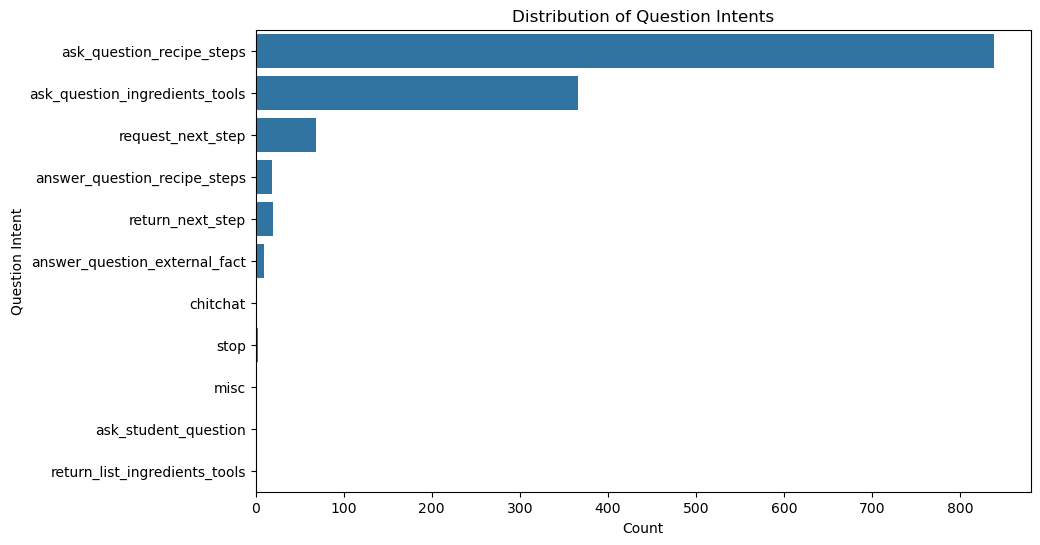

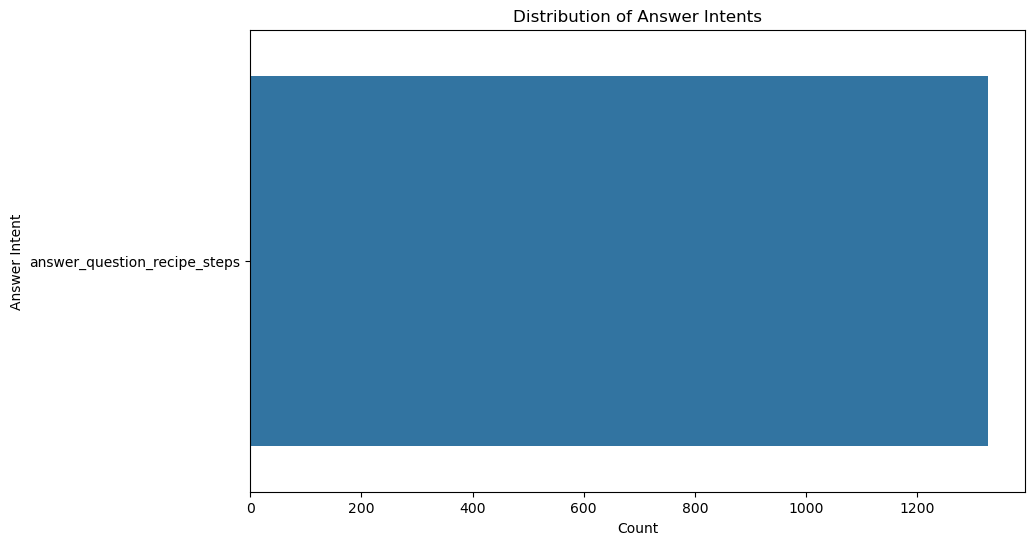

In [19]:
# Visualize the distribution of questions and answers
plt.figure(figsize=(10, 6))
sns.countplot(y='intent_question', data=df)
plt.title('Distribution of Question Intents')
plt.xlabel('Count')
plt.ylabel('Question Intent')
plt.show()

plt.figure(figsize=(10, 6))
sns.countplot(y='intent_answer', data=df)
plt.title('Distribution of Answer Intents')
plt.xlabel('Count')
plt.ylabel('Answer Intent')
plt.show()

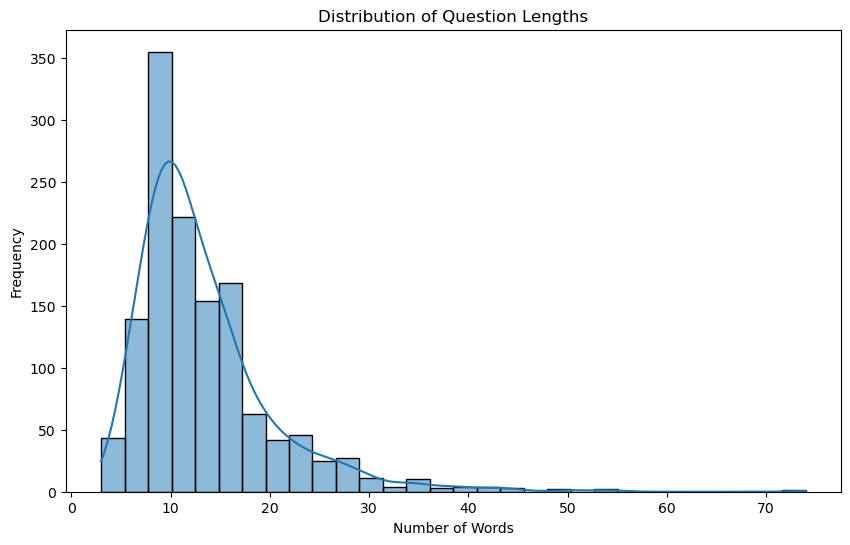

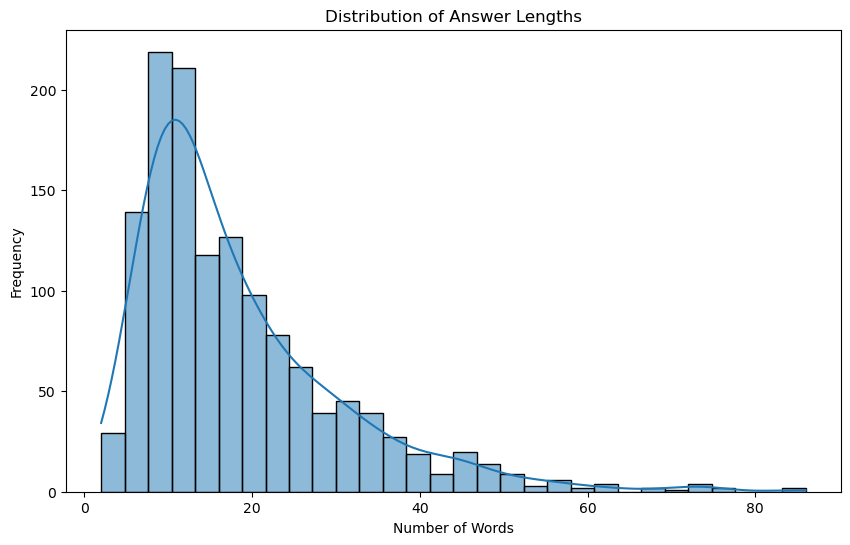

In [20]:
# Visualize the length of questions and answers
df['question_length'] = df['question'].apply(lambda x: len(x.split()))
df['answer_length'] = df['text_answer'].apply(lambda x: len(x.split()))

plt.figure(figsize=(10, 6))
sns.histplot(df['question_length'], bins=30, kde=True)
plt.title('Distribution of Question Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

plt.figure(figsize=(10, 6))
sns.histplot(df['answer_length'], bins=30, kde=True)
plt.title('Distribution of Answer Lengths')
plt.xlabel('Number of Words')
plt.ylabel('Frequency')
plt.show()

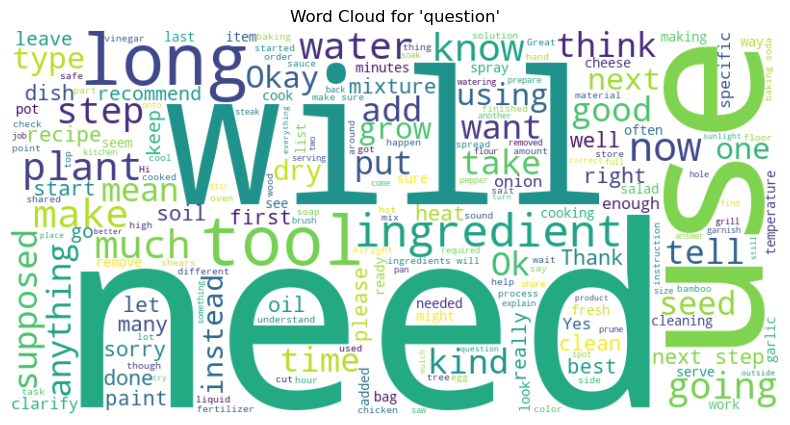

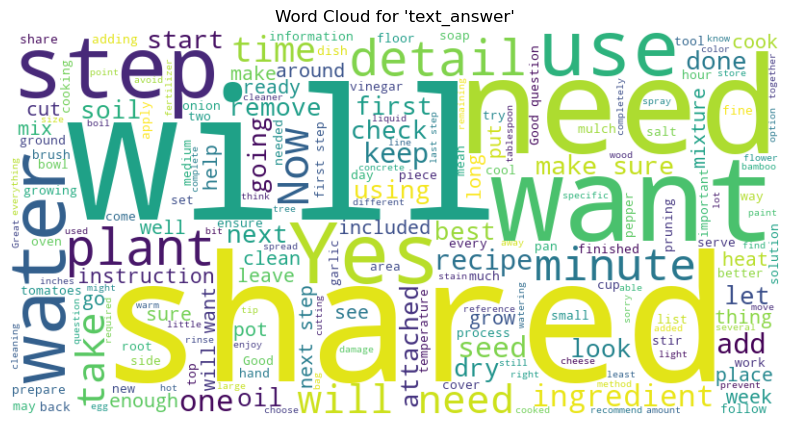

In [27]:
# Word Clouds for free text ('question', 'text_answer'):
for col in ['question', 'text_answer']:
    text = " ".join(df[col].astype(str))
    wordcloud = WordCloud(width=800, height=400, background_color="white").generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for '{col}'")
    plt.show()

Number of questions per conversation:
          conversation_id  num_questions
0    Wizard-of-Task-diy-1              2
1   Wizard-of-Task-diy-10              3
2  Wizard-of-Task-diy-100              5
3  Wizard-of-Task-diy-101              1
4  Wizard-of-Task-diy-102              3

Basic statistics about the number of questions per conversation:
count    484.000000
mean       2.743802
std        1.805347
min        1.000000
25%        1.000000
50%        2.000000
75%        3.000000
max       14.000000
Name: num_questions, dtype: float64


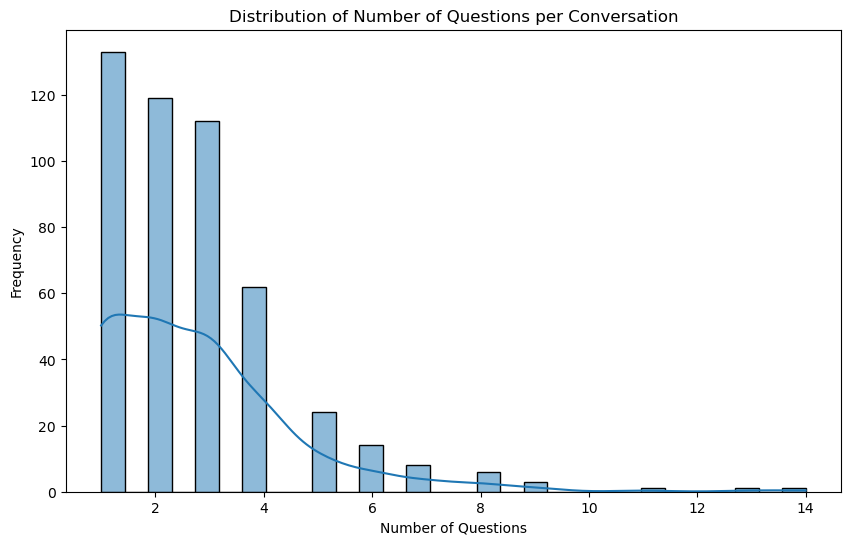

In [28]:
# Group by 'conversation_id' and count the number of questions per conversation
questions_per_conversation = df.groupby('conversation_id').size().reset_index(name='num_questions')

# Display the first few rows of the result
print("Number of questions per conversation:")
print(questions_per_conversation.head())

# Basic statistics about the number of questions per conversation
print("\nBasic statistics about the number of questions per conversation:")
print(questions_per_conversation['num_questions'].describe())

# Visualize the distribution of the number of questions per conversation
plt.figure(figsize=(10, 6))
sns.histplot(questions_per_conversation['num_questions'], bins=30, kde=True)
plt.title('Distribution of Number of Questions per Conversation')
plt.xlabel('Number of Questions')
plt.ylabel('Frequency')
plt.show()

## Shut down notebook resources

In [12]:
%%html

<p><b>Shutting down your kernel for this notebook to release resources.</b></p>
<button class="sm-command-button" data-commandlinker-command="kernelmenu:shutdown" style="display:none;">Shutdown Kernel</button>
        
<script>
try {
    els = document.getElementsByClassName("sm-command-button");
    els[0].click();
}
catch(err) {
    // NoOp
}    
</script>

In [13]:
%%javascript

try {
    Jupyter.notebook.save_checkpoint();
    Jupyter.notebook.session.delete();
}
catch(err) {
    // NoOp
}

<IPython.core.display.Javascript object>